In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json


In [2]:
df = pd.read_json("/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json", lines = True)

In [3]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

headlines = []
labels = df['is_sarcastic'].values

for headline in df['headline']:
    headline = headline.lower() # lowercase the headline
    headline = headline.replace("isn't", "is not")
    headline = headline.replace("didn't", "did not")
    headline = headline.replace("couldn't", "could not")
    headline = headline.replace("can't", "cannot")
    headline = headline.replace("haven't", "have not")
    headline = headline.replace("don't", "do not")
    headline = headline.replace("shouldn't", "should not")
    headline = headline.replace("he's", "he is")
    headline = headline.replace("she's", "she is")
    headline = re.sub(r'[^\w\s]', '', headline)
    headline = headline.strip() # remove extra spaces around the sentence
    headline = word_tokenize(headline) # first tokenize the headline into words
    headline = [w + " " for w in headline if w not in stop_words] # remove stop words
    headline = [lemmatizer.lemmatize(w) + " " for w in headline] # Lemmatize word(reduce word to their base/dictionary form)
    headline = "".join(headline)
    headlines.append(headline)

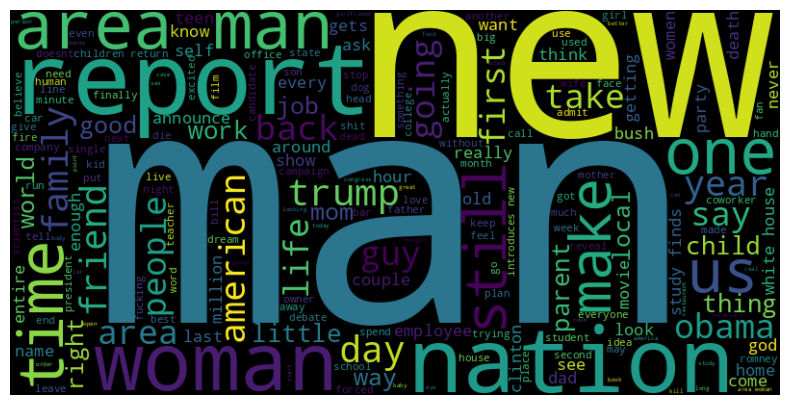

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

sarcastic_headlines = [headline for headline, label in zip(headlines, labels) if label == 1]

word_cloud = WordCloud(width = 800, height = 400).generate(' '.join(sarcastic_headlines))

plt.figure(figsize=(10, 5))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

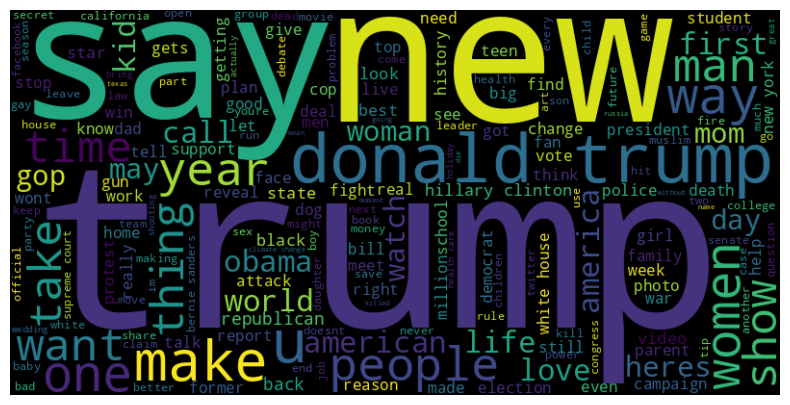

In [6]:
serious_headlines = [headline for headline, label in zip(headlines, labels) if label == 0]

word_cloud = WordCloud(width = 800, height = 400).generate(' '.join(serious_headlines))

plt.figure(figsize=(10, 5))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [7]:
print(len(headlines))
print(len(labels))

26709
26709


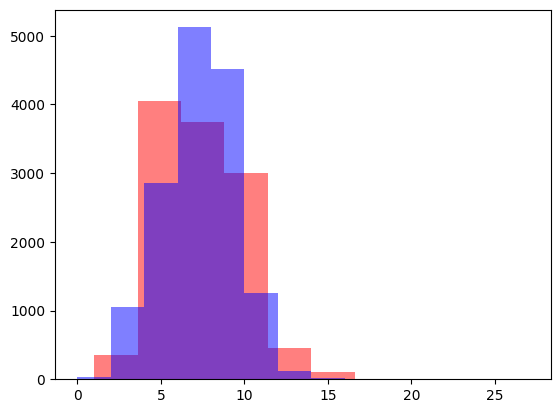

In [8]:
sarcastic_headline_lengths = [len(headline.split()) for headline in sarcastic_headlines]
plt.hist(sarcastic_headline_lengths, alpha = 0.5, color = "red", label = "Sarcastic")
serious_headline_lengths = [len(headline.split()) for headline in serious_headlines]
plt.hist(serious_headline_lengths, alpha = 0.5, color = "blue", label = "Serious")
plt.show()

In [9]:
training_size = 21000

training_headlines = headlines[:training_size]
testing_headlines = headlines[training_size:]
training_labels = labels[:training_size]
testing_labels = labels[training_size:]

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

oov_tok = "<OOV>"

tk = Tokenizer(num_words = 10000, oov_token = oov_tok)
tk.fit_on_texts(training_headlines)

training_sequences = tk.texts_to_sequences(training_headlines)

training_padded = pad_sequences(
    training_sequences,
    maxlen = 15,
    padding = 'post',
    truncating = 'post'
)

testing_sequences = tk.texts_to_sequences(testing_headlines)

testing_padded = pad_sequences(
    testing_sequences,
    maxlen = 15,
    padding = 'post',
    truncating = 'post'
)

2024-06-13 04:40:23.758628: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 04:40:23.758691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 04:40:23.760647: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
training_padded = np.array(training_padded)
testing_padded = np.array(testing_padded)
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [14]:
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras import Sequential

model = Sequential([
    Embedding(10000, 16),
    GlobalAveragePooling1D(),
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

history = model.fit(
    training_padded, training_labels,
    epochs = 30,
    validation_data = (testing_padded, testing_labels)
)



Epoch 1/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6100 - loss: 0.6478 - val_accuracy: 0.7893 - val_loss: 0.4513
Epoch 2/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8421 - loss: 0.3643 - val_accuracy: 0.7989 - val_loss: 0.4264
Epoch 3/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8876 - loss: 0.2712 - val_accuracy: 0.8033 - val_loss: 0.4446
Epoch 4/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9135 - loss: 0.2196 - val_accuracy: 0.7998 - val_loss: 0.4810
Epoch 5/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9268 - loss: 0.1914 - val_accuracy: 0.7928 - val_loss: 0.5241
Epoch 6/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9374 - loss: 0.1653 - val_accuracy: 0.7903 - val_loss: 0.5626
Epoch 7/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9452 - loss: 0.1465 - val_accuracy: 0.7802 - val_loss: 0.6384
Epoch 8/30
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9508 - loss: 0.1304 - val_accuracy: 0.

Maximum validation accuracy: 0.8032930493354797


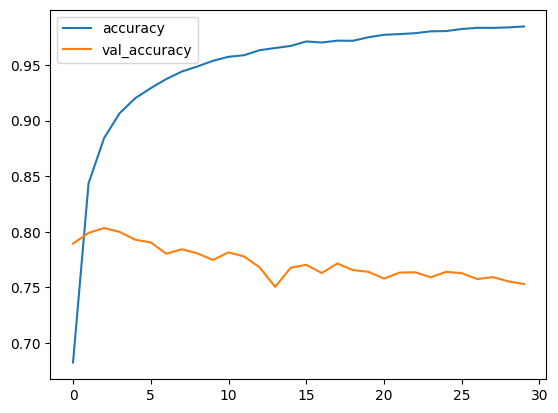

In [15]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
print("Maximum validation accuracy: {}".format(history_df['val_accuracy'].max()))

<Axes: >

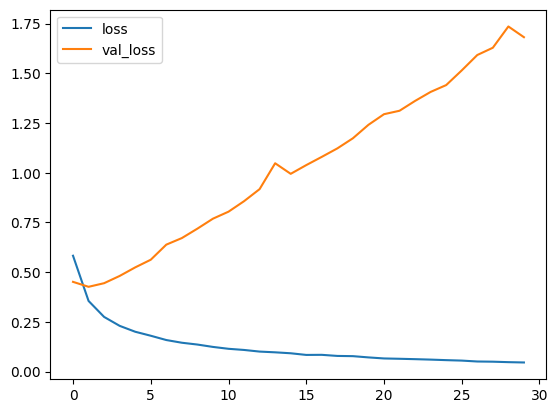

In [16]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()